# Line images and ratios from 30 Dor MUSE data

In [2]:
from pathlib import Path
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import cmasher as cm
from mpdaf.obj import Image
from astropy.io import fits
from astropy.wcs import WCS
import pandas as pd

sns.set_context("talk")
sns.set_color_codes()

In [3]:
DATADIR = Path("../data")
def p(s):
    """Return path to image file"""
    return str(DATADIR / f"lmc-30dor-ABCD-{s}-bin01-sum.fits")

In [4]:
imcont = Image("../data/lmc-30dor-ABCD-46-55-avcont.fits")

## The misterious molecular lines

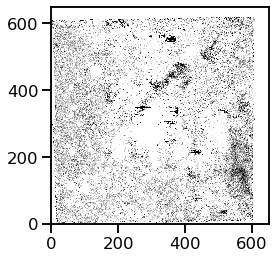

In [5]:
im9114 = Image(p("xxx-9114"))
im9112c = Image(p("CONT-9112"))

im9114.data -= im9112c.data
im9114.plot(vmin=-10, vmax=50, cmap="gray_r")

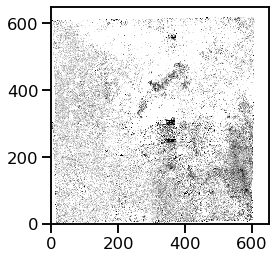

In [6]:
im8152 = Image(p("xxx-8152"))

im8152.plot(vmin=-10, vmax=50, cmap="gray_r")

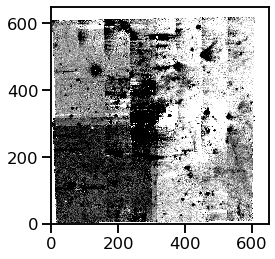

In [7]:
im8727 = Image(p("ci-8727"))
im8727.plot(vmin=-10, vmax=50, cmap="gray_r")

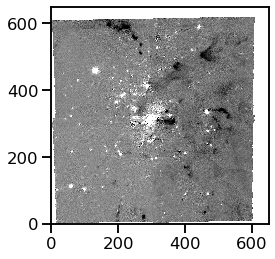

In [8]:
im8730c = Image(p("CONT-8730"))
im8727.data -= im8730c.data

im8727.plot(vmin=-150, vmax=150, cmap="gray_r")

## Remap Brackett gamma IR line

This comes from Sherry Weh

In [11]:
BIGDATAPATH = Path.cwd().parent / "big-data" / "30-Dor-Radio"

In [12]:
hdu_brg = fits.open(BIGDATAPATH / "30DOR_BRG_FL_SCCY.fits")[0]

Load a random Paschen line to get the MUSE wcs

In [13]:
hdu_pa = fits.open(p("hi-9229"))[0]

In [14]:
from reproject import reproject_interp

Reproject the near-IR map to the MUSE grid

In [15]:
brg_ABCD = reproject_interp(hdu_brg, hdu_pa.header, return_footprint=False)

And save to a file

In [17]:
fits.PrimaryHDU(
    data=brg_ABCD, 
    header=hdu_pa.header,
).writeto(
    DATADIR / "lmc-30dor-ABCD-hi-21661-reproject.fits",
    overwrite=True,
)

In [28]:
hdu_brg.header["BUNIT"]

'counts/s'

Is that really the brightness units of the image?

## H I line ratios for reddening

In [18]:
hifiles = DATADIR.glob(f"lmc-30dor-ABCD-hi-*-bin01-sum.fits")
sorted(hifiles)

[PosixPath('../data/lmc-30dor-ABCD-hi-4861-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-ABCD-hi-8467-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-ABCD-hi-8545-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-ABCD-hi-8598-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-ABCD-hi-8665-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-ABCD-hi-8750-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-ABCD-hi-8863-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-ABCD-hi-9015-bin01-sum.fits'),
 PosixPath('../data/lmc-30dor-ABCD-hi-9229-bin01-sum.fits')]

In [19]:
im4861 = Image(p("hi-4861"))
im8467 = Image(p("hi-8467"))
im8545 = Image(p("hi-8545"))
im8598 = Image(p("hi-8598"))
im8665 = Image(p("hi-8665"))
im8750 = Image(p("hi-8750"))
im9229 = Image(p("hi-9229"))

In [34]:
im21661 = 1e20 * Image(str(DATADIR / "lmc-30dor-ABCD-hi-21661-reproject.fits"))

In [22]:
im6563 = Image("../data/MUSE_R136toWill/GAUS_Ha6562.8_060_Will.fits")
saveunit = im6563.unit
sig6563 = Image("../data/MUSE_R136toWill/GAUS_Ha6562.8_060_Will.fits", ext=3)
im6563.data *= sig6563.data / 1.25
im6563.unit = saveunit

In [23]:
im6563.unit

Unit("1e-20 erg / (Angstrom cm2 s)")

In [24]:
im7751 = Image(p("ariii-7751"))
im7136 = Image(p("ariii-7136"))
(im7751 / im7136).data.mean()

0.2670340102039979

In [36]:
np.nanmedian(im21661.data), np.nanmedian(im9229.data.data)

(171.89079455039325, 3255.655932680915)

In [82]:
from astropy.convolution import convolve, Gaussian2DKernel
kernel = Gaussian2DKernel(x_stddev=3.0)

<ipython-input-83-3b6e99e95bc7>:30: RuntimeWarning: invalid value encountered in true_divide
  rsmooth = convolve(im7751.data, kernel) / convolve(im7136.data, kernel)


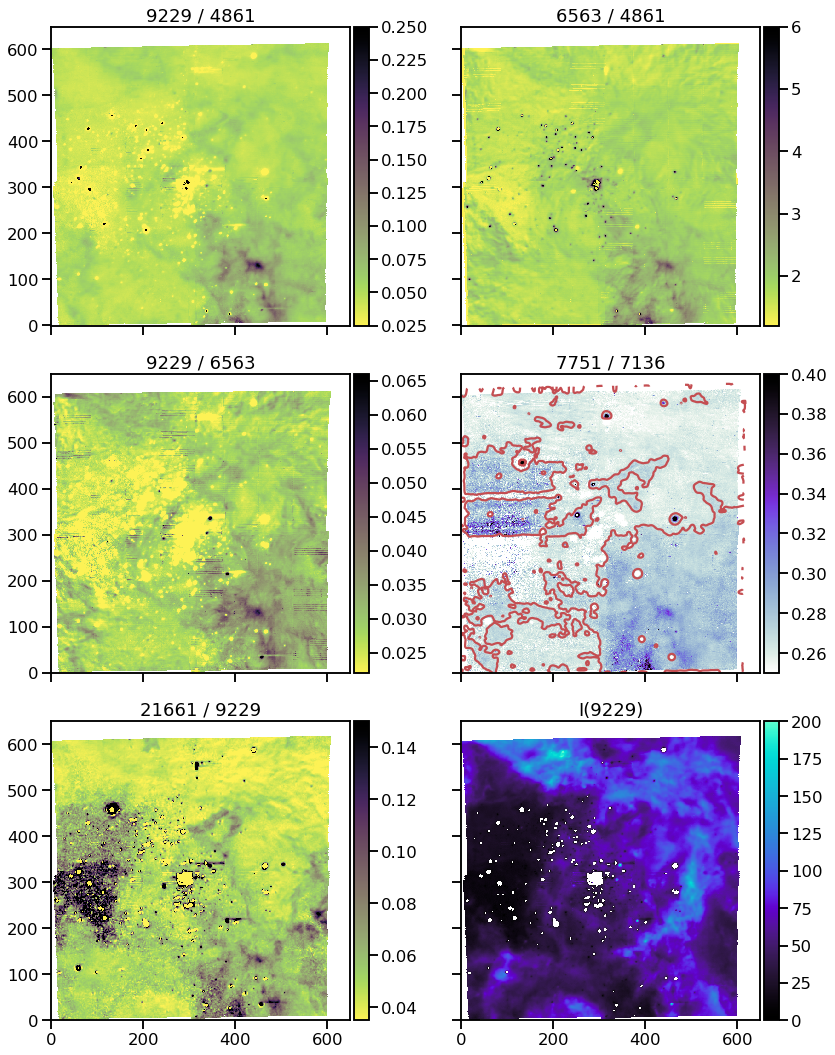

In [83]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15), sharex=True, sharey=True)
(im9229 / im4861).plot(
    vmin=0.025, vmax=0.25, 
    cmap=cm.ghostlight_r,
    ax=axes[0, 0],
    colorbar="v",
)
axes[0, 0].set_title("9229 / 4861")
(im6563 / im4861).plot(
    vmin=1.2, vmax=6.0, 
    cmap=cm.ghostlight_r,
    ax=axes[0, 1],
    colorbar="v",
)
axes[0, 1].set_title("6563 / 4861")
(im9229 / im6563).plot(
    vmin=0.022, vmax=0.066, 
    cmap=cm.ghostlight_r,
    ax=axes[1, 0],
    colorbar="v",
)
axes[1, 0].set_title("9229 / 6563")
(im7751 / im7136).plot(
    vmin=0.25, vmax=0.4, 
    cmap=cm.amethyst_r,
    ax=axes[1, 1],
    colorbar="v",
)

rsmooth = convolve(im7751.data, kernel) / convolve(im7136.data, kernel)
axes[1, 1].contour(rsmooth, levels=[0.266], colors="r")
axes[1, 1].set_title("7751 / 7136")

(im21661 / im9229).plot(
    vmin=0.035, vmax=0.15, 
    cmap=cm.ghostlight_r,
    ax=axes[2, 0],
    colorbar="v",
)
axes[2, 0].set_title("21661 / 9229")

np.sqrt(im9229).plot(
    #vmin=2.5, vmax=4.0, 
    vmin=0.0,
    vmax=2e2,
    cmap=cm.cosmic,
    ax=axes[2, 1],
    colorbar="v",
)
axes[2, 1].set_title("I(9229)")

fig.tight_layout()
...;

In general, there is a good correlatrion between all the reddening indicators


There are some cases, however, where the blue–red reddening and the red–infared are different.  For instance, the cloud at (x, y) = (400, 10) has a high 6563/4861 and high 7751/7136, but is not particularly visible in 9229 / 6563

But note that this same cloud is prominent in Br-gamma / 9229, which is odd.

Also, we need to improve the sky subtraction for the [Ar III] lines, since there is a clear variation between the 4 fields.

And another issue is the zero point in the Br-gamma map.  Presumably, that is what gives the dark Brg/9229 regions in the low brightness region to the West (where all other ratios suggest low extinction).

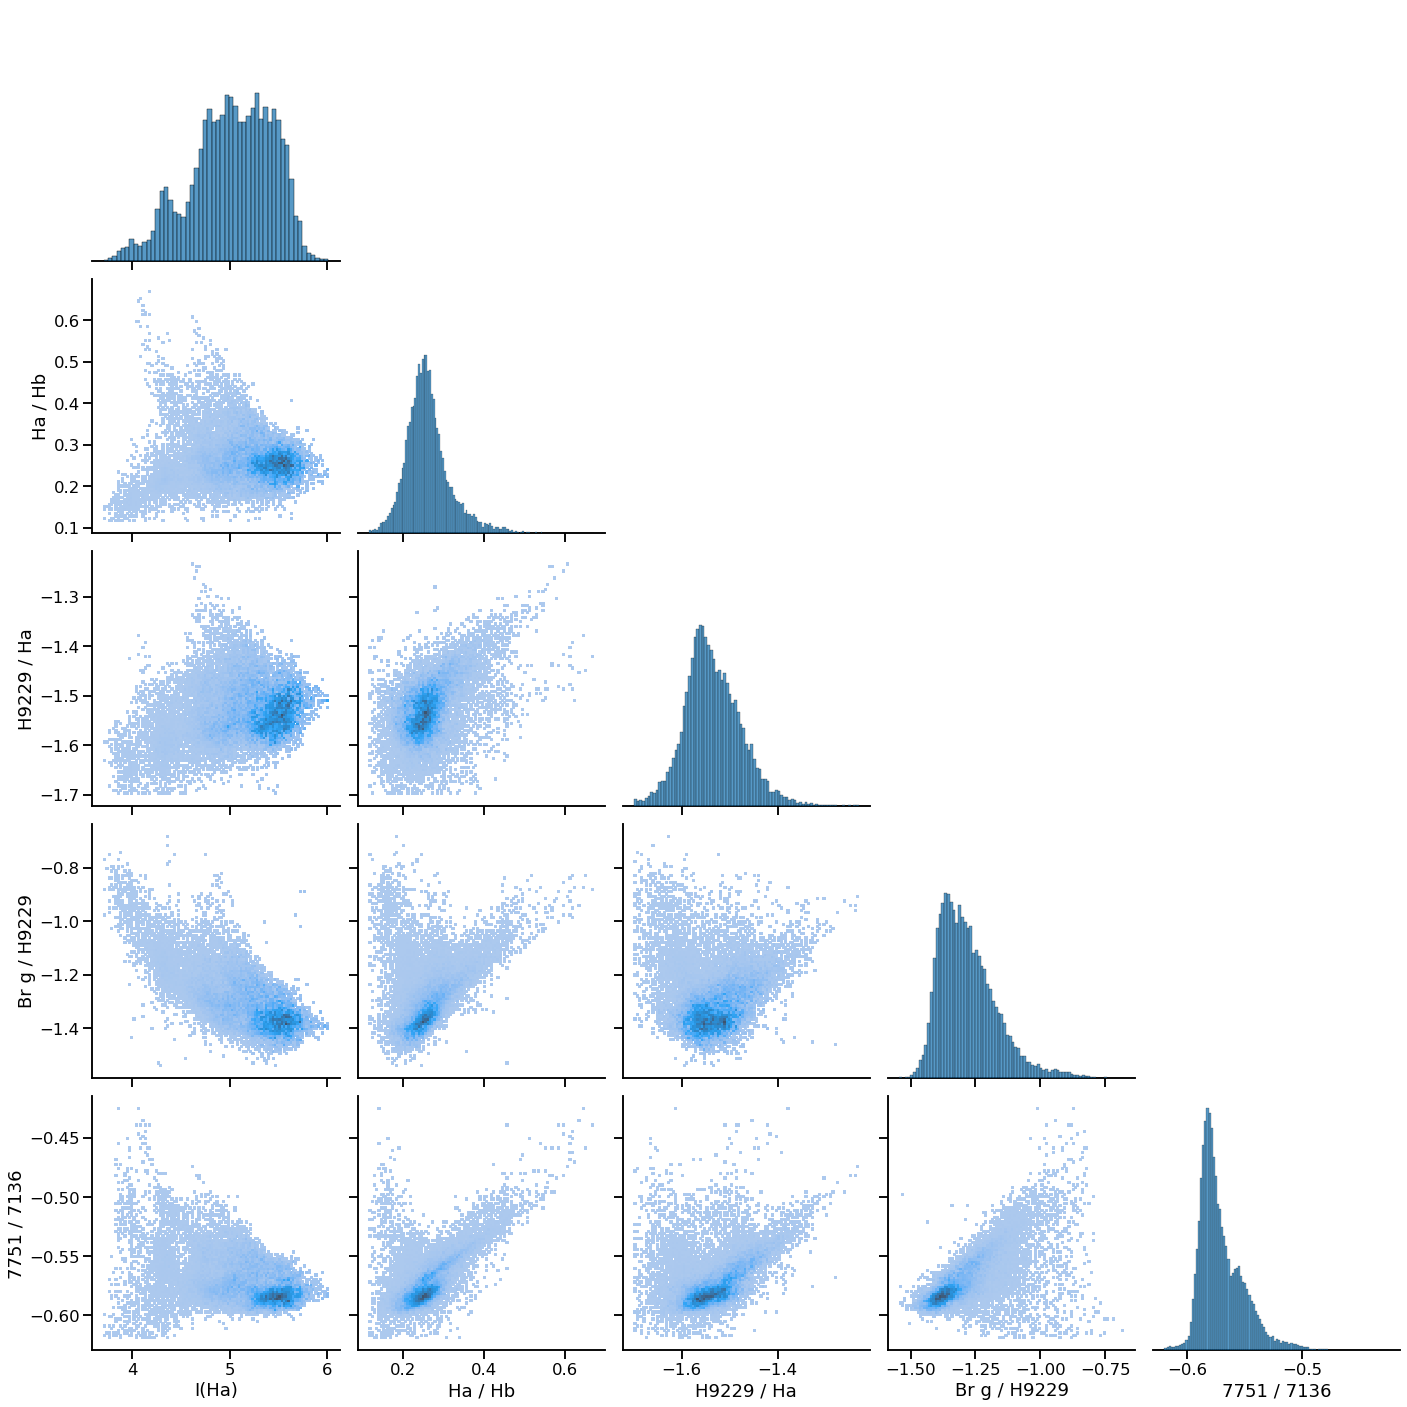

In [79]:
n = 4
r_hi_hb = im9229.rebin(n) / im4861.rebin(n)
r_ha_hb = im6563.rebin(n) / im4861.rebin(n)
r_hi_ha = im9229.rebin(n) / im6563.rebin(n)
r_ariii = im7751.rebin(n) / im7136.rebin(n)
r_bg_hi = im21661.rebin(n) / im9229.rebin(n)
i_ha = im6563.rebin(n)
m = ~r_hi_ha.data.mask & (imcont.rebin(n).data < 1e3)
m = m & (r_hi_ha.data > 0.02) & (r_hi_ha.data < 0.1)
m = m & (r_ha_hb.data > 1.3) & (r_ha_hb.data < 7.0)
m = m & (r_ariii.data > 0.24) & (r_ariii.data < 0.4)
m = m & (r_bg_hi.data > 0.025) & (r_bg_hi.data < 0.25)
m
df = pd.DataFrame(
    {
        "I(Ha)": np.log10(i_ha.data[m]),
        "Ha / Hb": np.log10(r_ha_hb.data[m]),
        "H9229 / Ha": np.log10(r_hi_ha.data[m]),
        "Br g / H9229": np.log10(r_bg_hi.data[m]),
        "7751 / 7136": np.log10(r_ariii.data[m]),
    }
)

g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
#       weights=im21661.rebin(n).data[m],
        weights=i_ha.data[m],
#        weights=r_hi_hb.data[m] - 0.025,
        bins=100,
    ),
)
...;

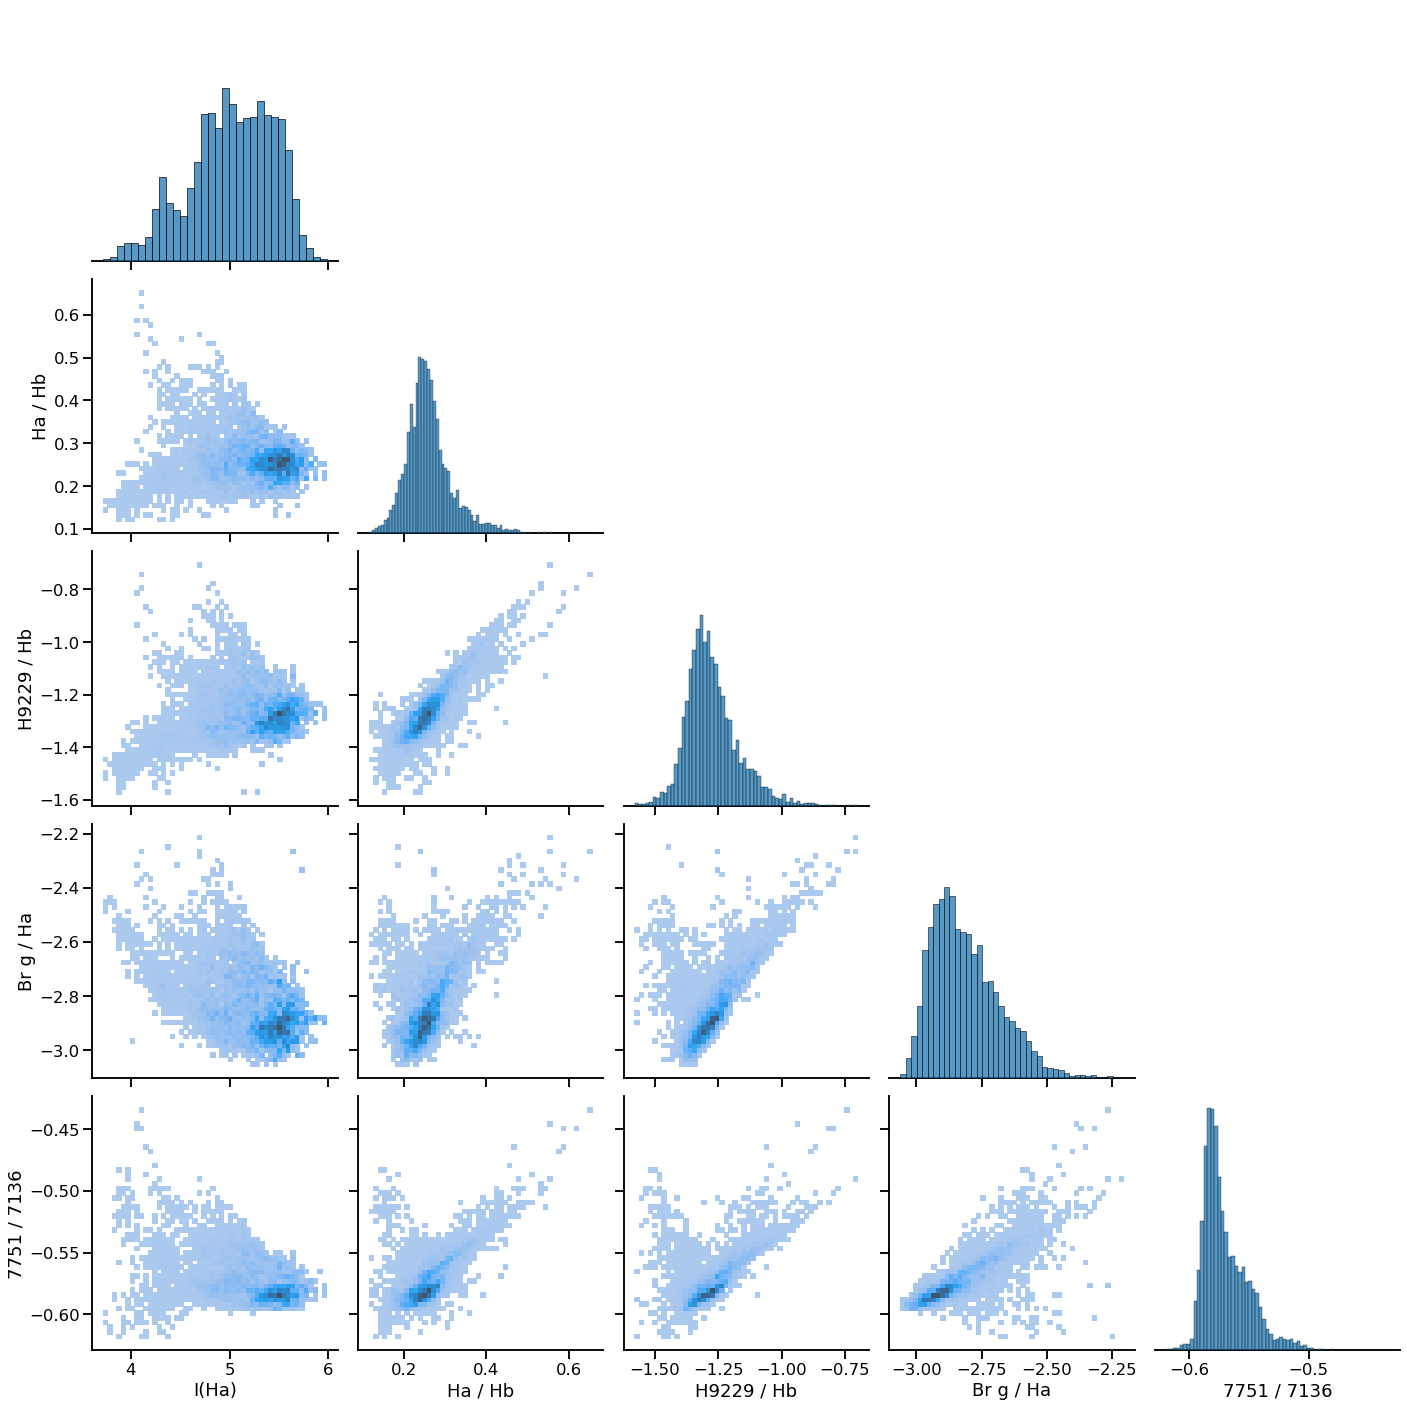

In [94]:
n = 8
r_hi_hb = im9229.rebin(n) / im4861.rebin(n)
r_ha_hb = im6563.rebin(n) / im4861.rebin(n)
r_ariii = im7751.rebin(n) / im7136.rebin(n)
r_bg_ha = im21661.rebin(n) / im6563.rebin(n)
i_ha = im6563.rebin(n)
m = ~r_hi_hb.data.mask & (imcont.rebin(n).data < 1e3)
m = m & (r_hi_hb.data > 0.026) & (r_hi_hb.data < 0.7)
m = m & (r_ha_hb.data > 1.3) & (r_ha_hb.data < 7.0)
m = m & (r_ariii.data > 0.24) & (r_ariii.data < 0.4)
m = m & (r_bg_ha.data > 0.0003) & (r_bg_ha.data < 0.01)
m
df = pd.DataFrame(
    {
        "I(Ha)": np.log10(i_ha.data[m]),
        "Ha / Hb": np.log10(r_ha_hb.data[m]),
        "H9229 / Hb": np.log10(r_hi_hb.data[m]),
        "Br g / Ha": np.log10(r_bg_ha.data[m]),
        "7751 / 7136": np.log10(r_ariii.data[m]),
    }
)

g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
#       weights=im21661.rebin(n).data[m],
        weights=i_ha.data[m],
#        weights=r_hi_hb.data[m] - 0.025,
        bins=50,
    ),
)
...;

These show very high correlations between the reddening indicators.  There is a subtle curvature in some of them though.

In particular, it looks like the infrared /optical ratios increase slower vs red/blue at higher extinctions.  *What could that mean?* *Does it make sense in terms of higher R_V?*

## The O++ lines

In [14]:
im4959 = Image(p("oiii-4959"))
im4931 = Image(p("oiii-4931"))
im4642 = Image(p("oii-4642"))
im4650 = Image(p("oii-4650"))

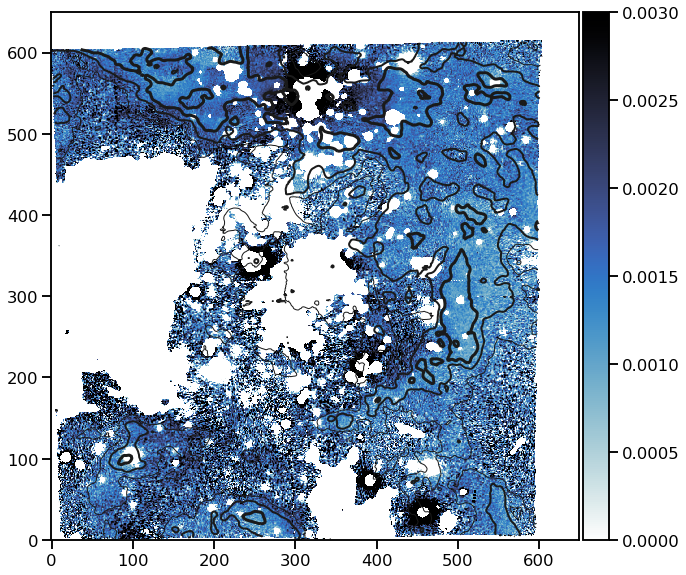

In [15]:
r_orl_cel = ((im4650 + im4642)/ im4959)
r_orl_cel.mask = r_orl_cel.mask | (im4959.data < 3e4) | (imcont.data > 1e3)
fig, ax = plt.subplots(figsize=(10, 10))
r_orl_cel.plot(vmin=0, vmax=0.003, cmap=cm.arctic_r, colorbar="v")
ax.contour(im4959.data, levels=[1e5, 2e5, 4e5], linewidths=[1.0, 2.0, 3.0], colors="k")

This shows that the collisional lines are relatively stronger where the intensity is highest.  And that teh permitted lines are relatively higher in the inner parts. 

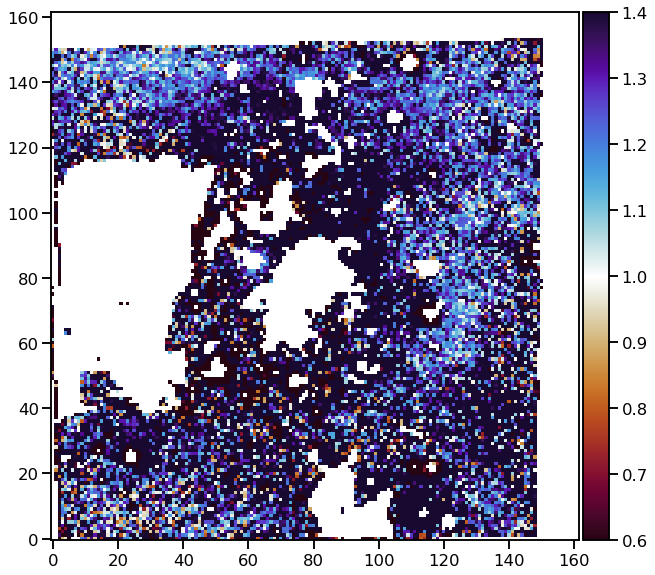

In [16]:
n = 4
im1, im2 = im4642.copy(), im4650.copy()
im1.mask = im1.mask | (im4959.data < 3e4) | (imcont.data > 1e3)
im2.mask = im1.mask
r = (im1.rebin(n) / im2.rebin(n))
fig, ax = plt.subplots(figsize=(10, 10))
r.plot(vmin=0.6, vmax=1.4, cmap=cm.fusion, colorbar="v")

In [17]:
im4740 = Image(p("ariv-4740"))
im7330 = Image(p("oii-7330"))

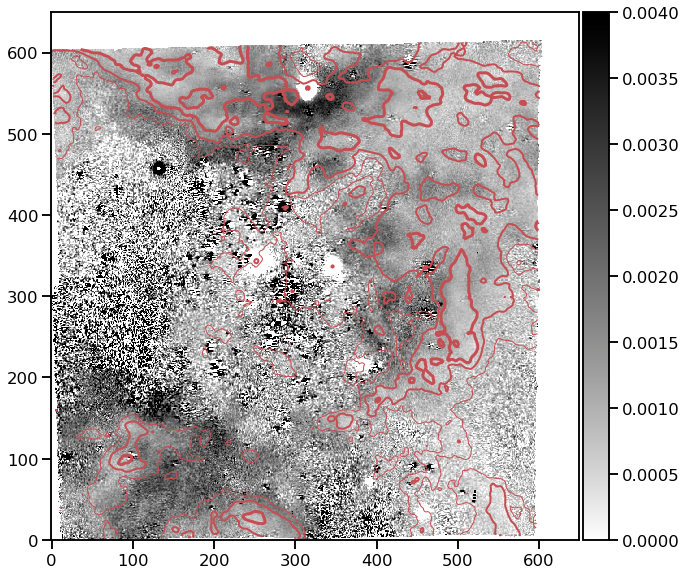

In [18]:
r_ariv_oiii = (im4740 / im4959)
fig, ax = plt.subplots(figsize=(10, 10))
r_ariv_oiii.plot(vmin=0.0, vmax=0.004, cmap=cm.neutral_r, colorbar="v")
ax.contour(im4959.data, levels=[1e5, 2e5, 4e5], linewidths=[1.0, 2.0, 3.0], colors="r")

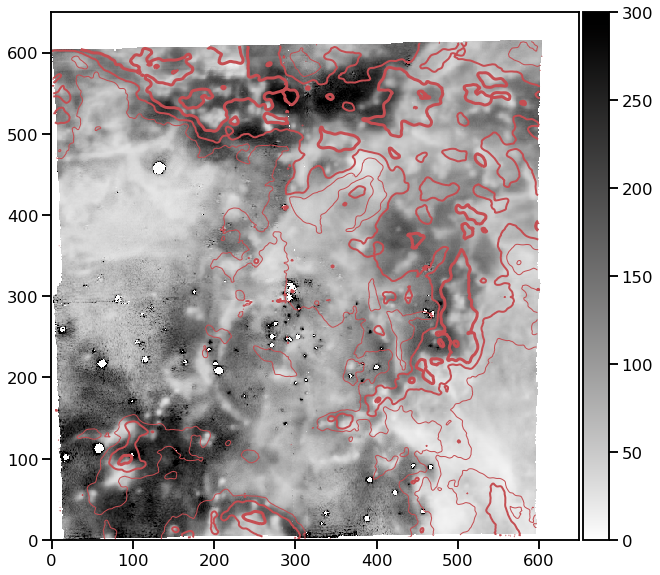

In [19]:
r_oiii_oii = (im4959 / im7330)
fig, ax = plt.subplots(figsize=(10, 10))
r_oiii_oii.plot(vmin=0.0, vmax=300.0, cmap=cm.neutral_r, colorbar="v")
ax.contour(im4959.data, levels=[1e5, 2e5, 4e5], linewidths=[1.0, 2.0, 3.0], colors="r")

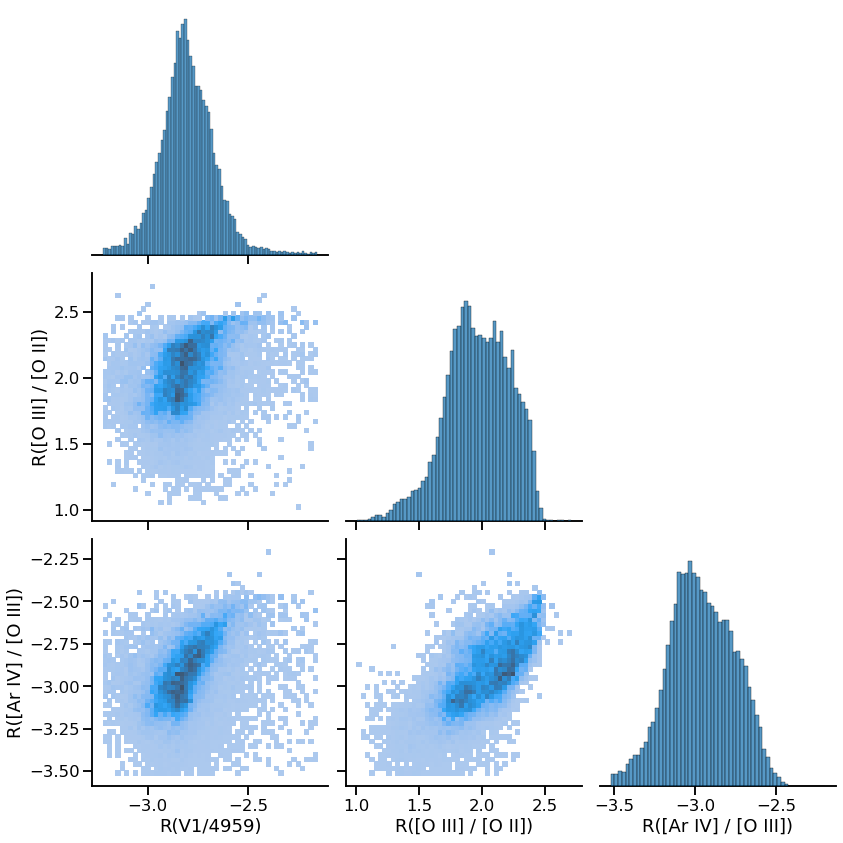

In [20]:
n = 4
m = ~r_orl_cel.rebin(n).data.mask
m = m & (r_oiii_oii.rebin(n).data > 3.0) & (r_oiii_oii.rebin(n).data < 600.0)
m = m & (r_ariv_oiii.rebin(n).data > 3e-4) & (r_ariv_oiii.rebin(n).data < 0.007)
m = m & (r_orl_cel.rebin(n).data > 6e-4) & (r_orl_cel.rebin(n).data < 0.007)
df = pd.DataFrame(
    {
        "R(V1/4959)": np.log10(r_orl_cel.rebin(n).data[m]),
        "R([O III] / [O II])": np.log10(r_oiii_oii.rebin(n).data[m]),
        "R([Ar IV] / [O III])": np.log10(r_ariv_oiii.rebin(n).data[m]),
    }
)

g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=im4740.rebin(n).data[m],
        bins=50,
    ),
);


## Look at the Raman wings